# AIML339 Assignment 3
## Matrix Profiles for Anomaly Detection and Time Series Dynamics

The matrix profile is primarily used to find repeating patterns and outliers in a single, univariate time series.. This is based on the principle of similarity joins - comparing a sub-sequence of the time series against itself, by computing the distance between each pair of subsequences. Matrix profile algorithms have the following properties:
- Domain agnostic
- Can be exact or approximate
- Only one hyperparameter (window length)
- Parallelizable
- Stream compatible
- Handles missing data

## Terms:
- **Motif**: A repeated pattern in the time series.
- **Discord**: An anomaly in the time series.




In [1]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config

### Load the Datasets
Datasets used:
- GenSyn (synthetic electricity prices)
- Electricity Authority Point of Connection WWD1102

In [2]:
gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])
gensyn_labels = pd.read_csv(r"data/GenSyn_labels2122.csv")
poc_raw    = pd.read_csv(r"data/2024-08-10_2025-08-10_pocWWD1102_WWD1103.csv")

C:\Users\lenno\AppData\Local\Temp\ipykernel_19940\840461730.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])
C:\Users\lenno\AppData\Local\Temp\ipykernel_19940\840461730.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])


In [13]:
gensyn = pd.concat([gensyn_raw, gensyn_labels], axis=1)
gensyn["time"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j")
gensyn["year"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j").dt.strftime("%yyyy")
gensyn["day_of_year"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j").dt.strftime("%j").astype(int)
#df_gensyn = gensyn.rename(columns={"energy_usage": "energy", "anomaly_label": "label"})

In [14]:
poc_raw.head()

,TradingDate,TradingPeriod,PublishDateTime,PointOfConnection,Island,IsProxyPriceFlag,DollarsPerMegawattHour
0,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1102,NI,N,834.55
1,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1103,NI,N,834.55
2,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1102,NI,N,831.84
3,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1103,NI,N,831.84
4,2024-08-10,1,2024-08-10T00:09:33.000+12:00,WWD1102,NI,N,833.55


In [15]:
poc = (poc_raw
    .where(poc_raw["PointOfConnection"] == "WWD1102")
    .groupby(["TradingDate", "TradingPeriod"], as_index=False)
    .agg({
        "DollarsPerMegawattHour": "mean"
    })[["DollarsPerMegawattHour", "TradingDate", "TradingPeriod"]]
)

# Join onto a complete list of start times (every half hour) to ensure no missing values

data_start = min(poc["TradingDate"])
data_end = max(poc["TradingDate"])

dates_df = pd.DataFrame(pd.date_range(start=data_start, end=data_end), columns=["TradingDate"])
periods = pd.DataFrame(range(1, 48+1), columns=["TradingPeriod"])
dates_df = dates_df.join(periods, how="cross")

dates_df["TradingDate"] = dates_df["TradingDate"].dt.date
poc["TradingDate"] = pd.to_datetime(poc["TradingDate"]).dt.date
poc = pd.merge(poc, dates_df, how="left", on=["TradingDate", "TradingPeriod"])
poc_series = poc.rename(columns={"DollarsPerMegawattHour": "energy"})


In [16]:
# cuda acceleration

#from numba import cuda
#gpus = [device.id for device in cuda.list_devices()]

### Using the matrix profile

In [17]:
window_size = 10

#matrix_profile = stumpy.gpu_stump(df_gensyn["energy"], m=window_size, device_id=gpus)
matrix_profile = stumpy.stump(df_gensyn["energy"], m=window_size)

In [18]:
matrix_profile

mparray([[0.3716703393165383, 171, -1, 171],
         [0.4458043443027531, 532, -1, 532],
         [0.25906144641735745, 533, -1, 533],
         ...,
         [0.21808146105050724, 355, 355, -1],
         [0.22344179621309135, 356, 356, -1],
         [0.24447764365659697, 356, 356, -1]],
        shape=(721, 4), dtype=object)

In [19]:
from helpers import plot_features, plot_detection

In [20]:
gensyn.head()

,year_day_of_year,season,temperature,humidity,energy_usage,anomaly_label,time,year,day_of_year
0,2021 1,summer,19.708638,78.625889,11.731837,1,2021-01-01,21yyy,1
1,2021 2,summer,20.703554,78.350411,13.453957,1,2021-01-02,21yyy,2
2,2021 3,summer,21.339178,82.736788,15.393096,1,2021-01-03,21yyy,3
3,2021 4,summer,20.823304,79.921728,16.657684,1,2021-01-04,21yyy,4
4,2021 5,summer,22.277698,80.406175,16.927320,1,2021-01-05,21yyy,5


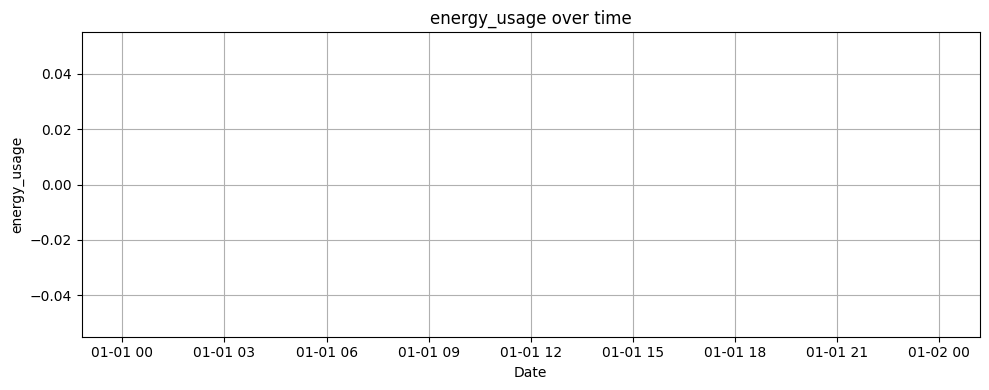

In [21]:
plot_features(gensyn, start_day=1, end_day=100, start_year="2021", end_year="2021", features=["energy_usage"])

In [130]:
gensyn

,year_day_of_year,season,temperature,humidity,energy_usage,anomaly_label,time
0,2021 1,summer,19.708638,78.625889,11.731837,1,2021-01-01
1,2021 2,summer,20.703554,78.350411,13.453957,1,2021-01-02
2,2021 3,summer,21.339178,82.736788,15.393096,1,2021-01-03
3,2021 4,summer,20.823304,79.921728,16.657684,1,2021-01-04
4,2021 5,summer,22.277698,80.406175,16.927320,1,2021-01-05
...,...,...,...,...,...,...,...
725,2022 361,summer,24.648768,79.422802,18.579817,1,2022-12-27
726,2022 362,summer,24.362897,80.541095,19.394421,1,2022-12-28
727,2022 363,summer,24.730546,85.748327,20.060006,1,2022-12-29
728,2022 364,summer,26.975549,81.506959,20.840548,1,2022-12-30
